# Anomaly Detection

### Import libaries used
- **Note**: Ensure that the **path** of 'eco-tools' is configured to your computer

In [1]:
import pandas as pd
import numpy as np
import sys
#import os, sys
#sys.path.append(os.path.join(os.path.dirname('__file__'), "src"))
#import os, sys
#sys.path.append(os.path.join(os.path.dirname('__file__'), "src/config"))
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from src.data_helper import *
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Find point to train on
- **Note**: Esure that only **ONE** point will be used

In [2]:
#search for point 
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters
- **start**: format `'YYYY-MM-DD'`
- **end**: format `'YYYY-MM-DD'` or `'*'` for up to time now
- **interval**: can be `'1h'` - `'nh'` where **n** is any number of hour intervals, can also use `'m'` for minutes or `'s'` for seconds
- **calculation**: preferred method is `'summary'`

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

## Pull the point's data from PI using eco-tools

**`print_report()`**
-------
Generates report of the percentage of NaN values in the data as well as the number of points that are NaN

**parameters**: 

`df`**-**  pandas `DataFrame` generated by the `get_stream_by_point`

`show_plot`**-** `bool` whether to show the data retrieved from PI

`separate_plots`**-** `bool` if several points where passed and want to see each point in it's own plot

**returns**:
-`None`


Grabbing WebIDs ...
WebID collection complete!
10:57:00: Sending API request... Chunk 1 of 1
10:57:01: Response recieved for 1 tags! (1.5)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31710


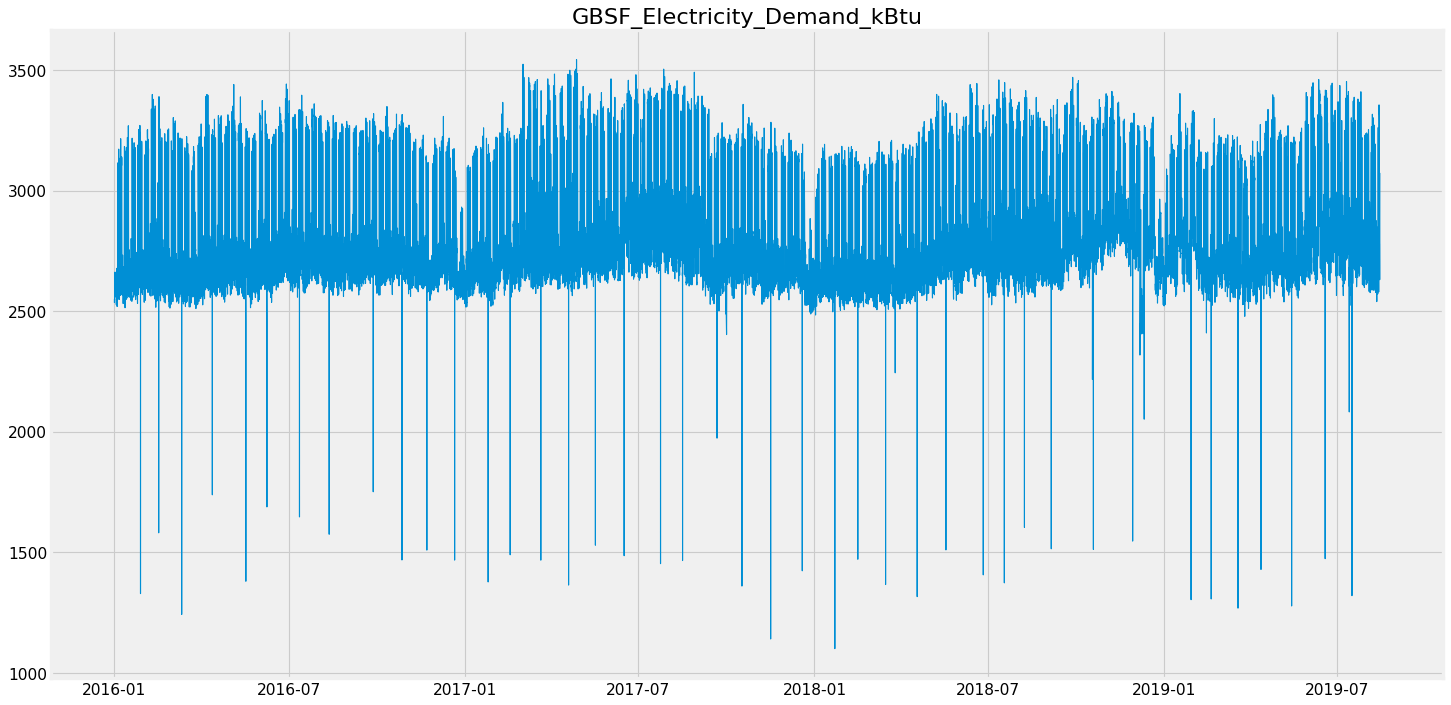

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

## Load arguments to create model and remove anomalies

In [17]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest' or None
    'model_type': 'Random Forest',
    
################################### Data Pre-processing ################################ 
    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if user wants the data to be cleaned prior to model generation 
    'clean_data': True,
    
    
    #clean_type can be either 'value' (any points below or above a threshold will be cut out)
    # or 'iqr' (interquantile range)
    'clean_type': 'value',

    
    # if clean_type is IQR then determine the IQR to cut at, an int or float value (ie. 1.5 or 2)
    #if clean is 'value' then pass the value  or a list as shown below
    #if values the threshold =  [lower_bound, upper_bound] (ie. [1200, 3500])
    'threshold': [2500, 3500],
    
    #This will determine if the user wants to see the plot in which the cutoff value(s) are shown 
    'show_cutoff_plot': True,
    
    #This will show if the user wants to see the plot with the cleaned training data and test data combined
    'show_cleaned_plot': True,
    
    #determine what method to use when cleaning the data: 'bfill' (back fill) or 'ffill' (foward fill)  
    'method': 'bfill',
    
########################################### Model Specific Parameters ###################    
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True,
    
    #For LSTM only,this will generate the plot of the nueral network's validation and mae loss as a function of epochs
    'show_training_plot' : True,
    
    #show the plots of Training (Modeled vs Actual) and Testing (Modeled vs Actual) plots
    'show_results_plots' : True,
    
##################################################### Anomalies #######################
   
    #This will determine if the user wants to see the plot with the anomalies
    'show_anomalies_plot': True,
    
    #This will deteremine if the user wants to see a plot with the removed anomalies
    'show_removed_anomalies_plot': True
    
    

}

In [18]:
check_kwargs(kwargs)

'Good values!'

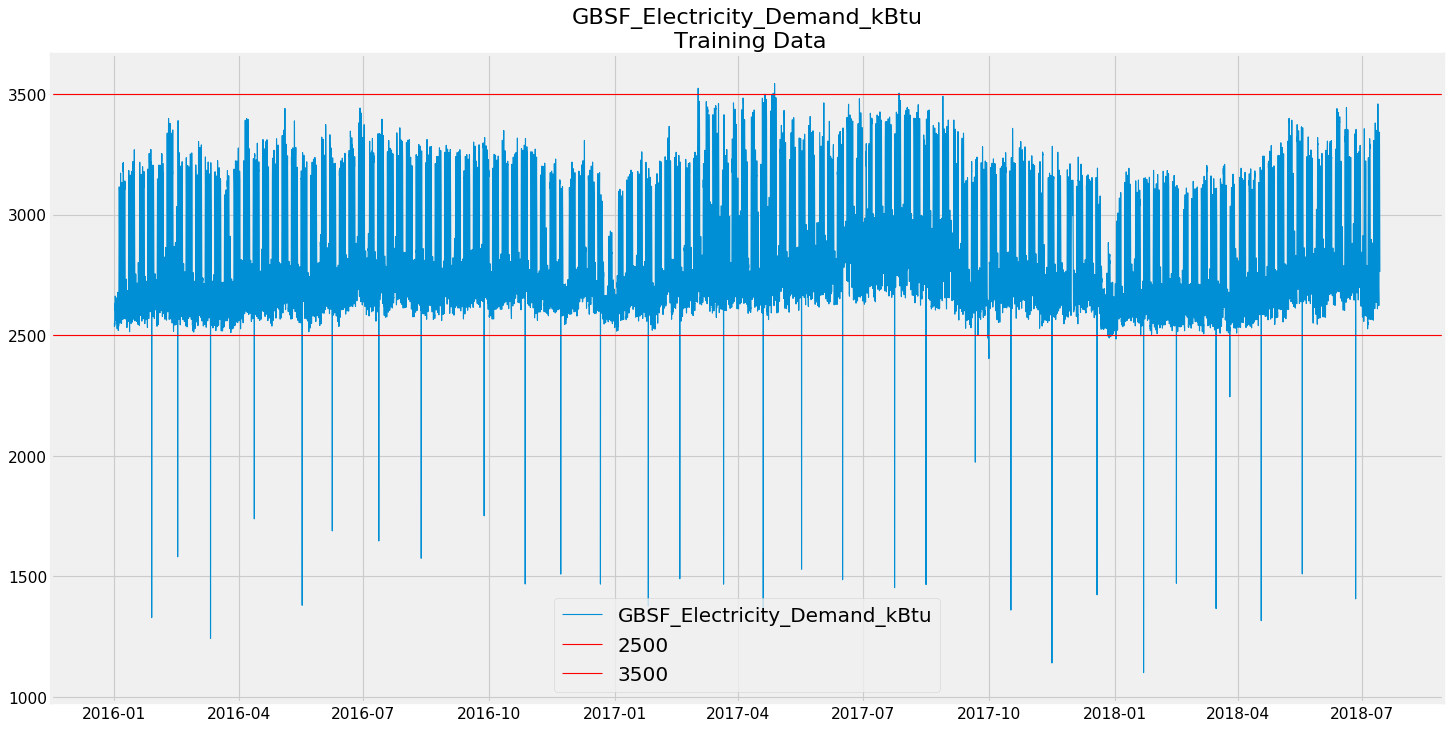

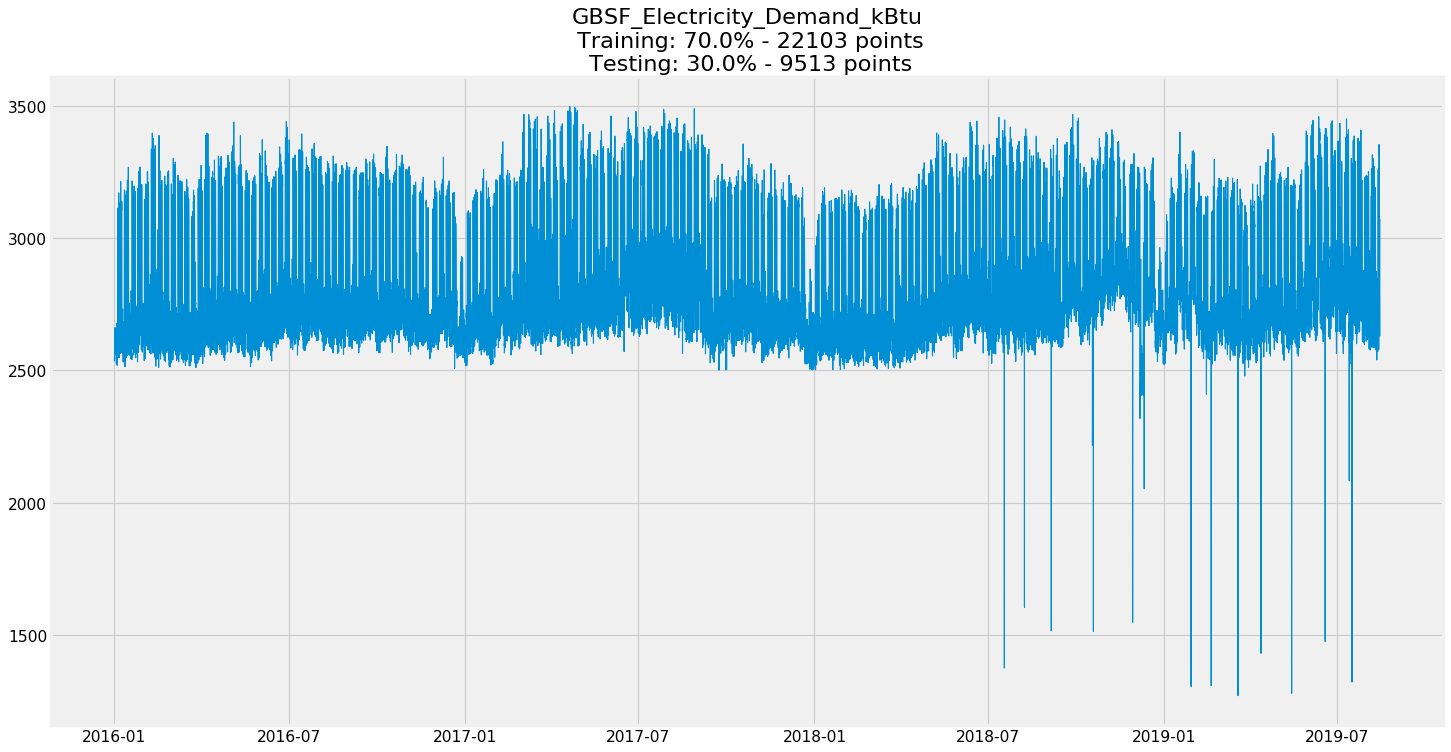

In [19]:
if kwargs['model_type'] is not None:
    df1 = split_and_clean(df, kwargs)

In [20]:
#plot_decomposed_data(df1[point[0]], kwargs)

Grabbing WebIDs ...
WebID collection complete!
10:59:32: Sending API request... Chunk 1 of 1
10:59:35: Response recieved for 3 tags! (3.33)
Removed: 0 rows
X_train original shape: (22199, 47)
X_train droppped shape: (22199, 47)
ytrain original shape: (22199,)
y_train dropped shape: (22199,)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


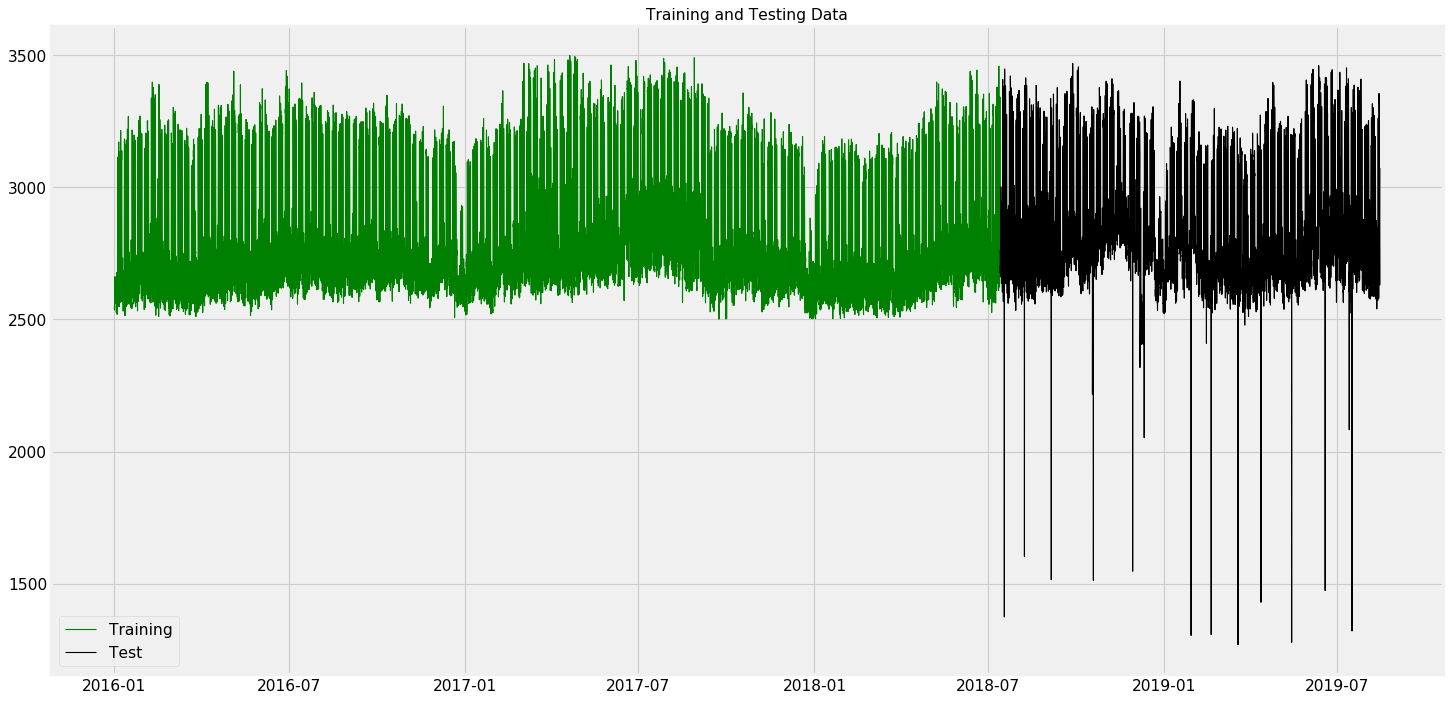

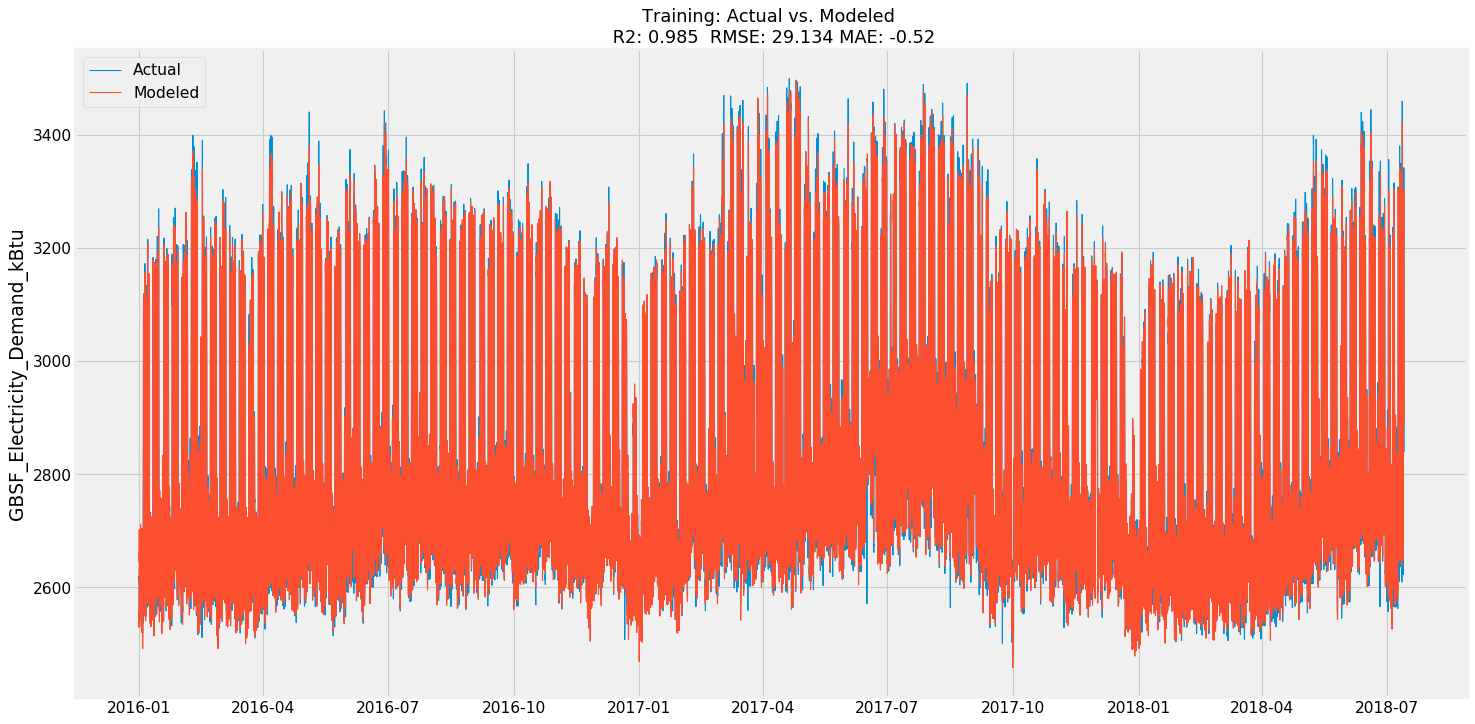

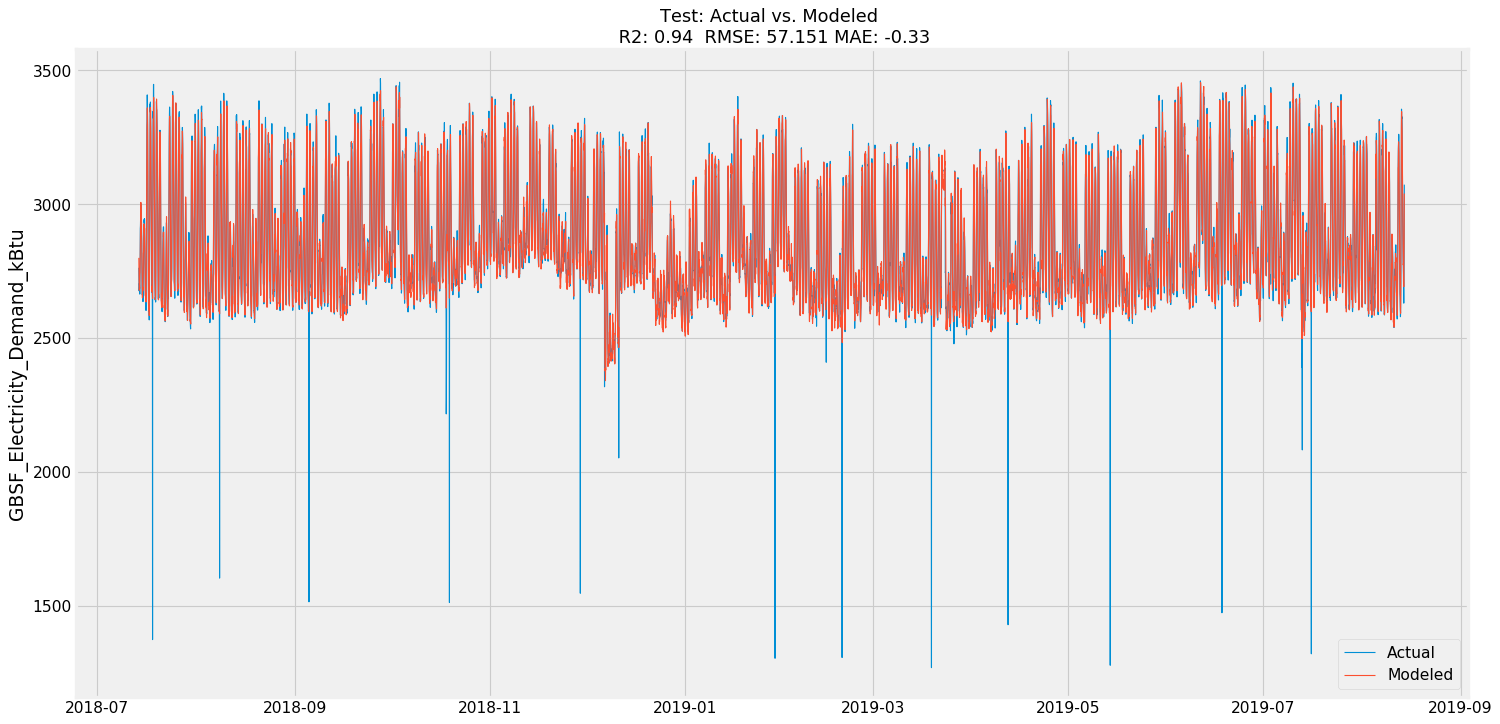

In [21]:
from src.model_generator import *
#model,X_train, X_test, y_train, y_test, scaler , train_idx, test_idx, data = create_model(df1, kwargs)
if kwargs['model_type'] is not None:
    train_df, test_df = create_model(df1, kwargs)
else:
    df3 = create_model(df, kwargs)
    test_df = df3.copy()
    del df3

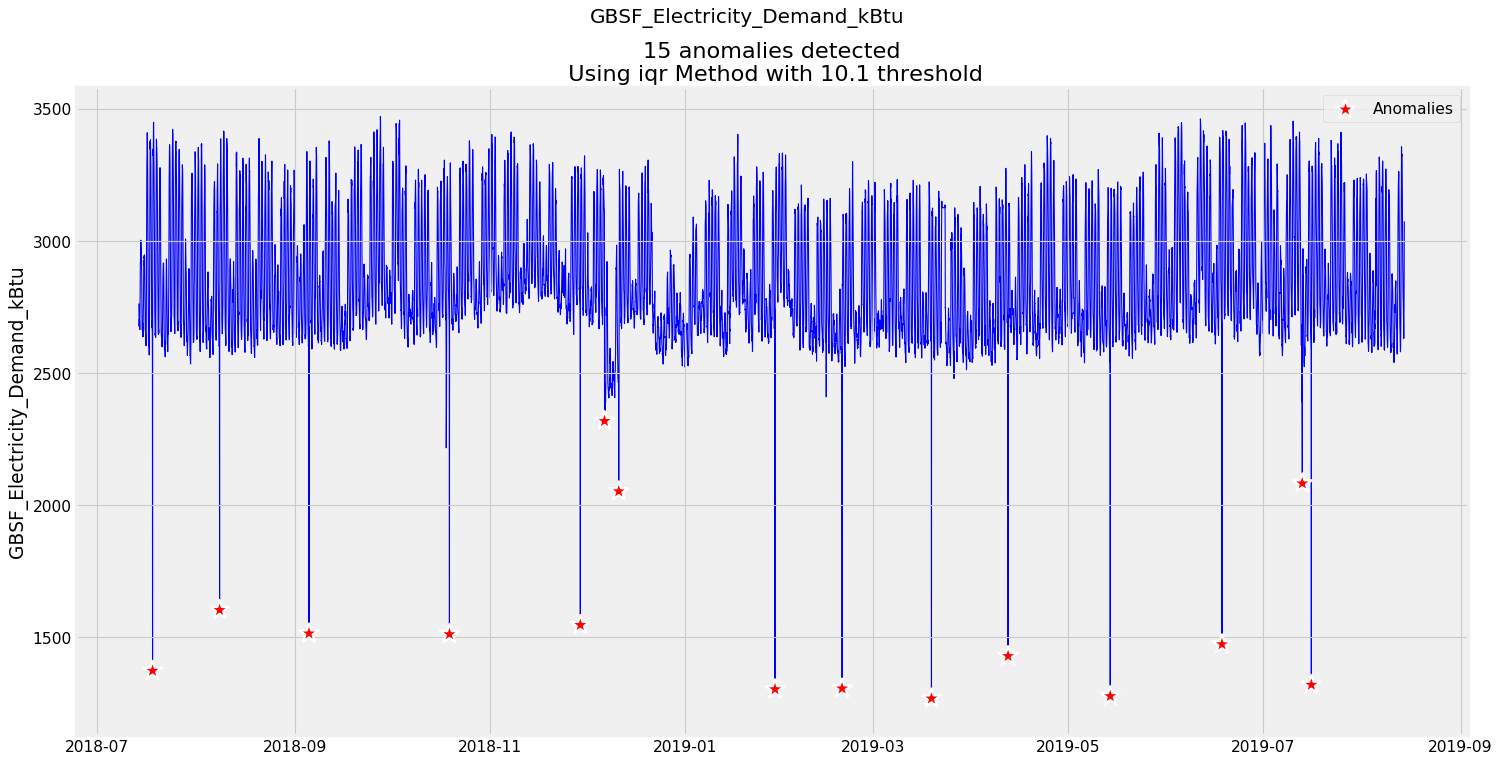

In [22]:
args = {'anomalies_method': 
                    {'iqr': 10.1}  }

a_df = find_anomalies(test_df,args, kwargs)

In [11]:
#a_df.loc[(a_df.Anomalies == 1)]
#test_df

Number of Points (pre clean): 9515
Removing 16 anomalies...
Number of Points (post clean): 9499


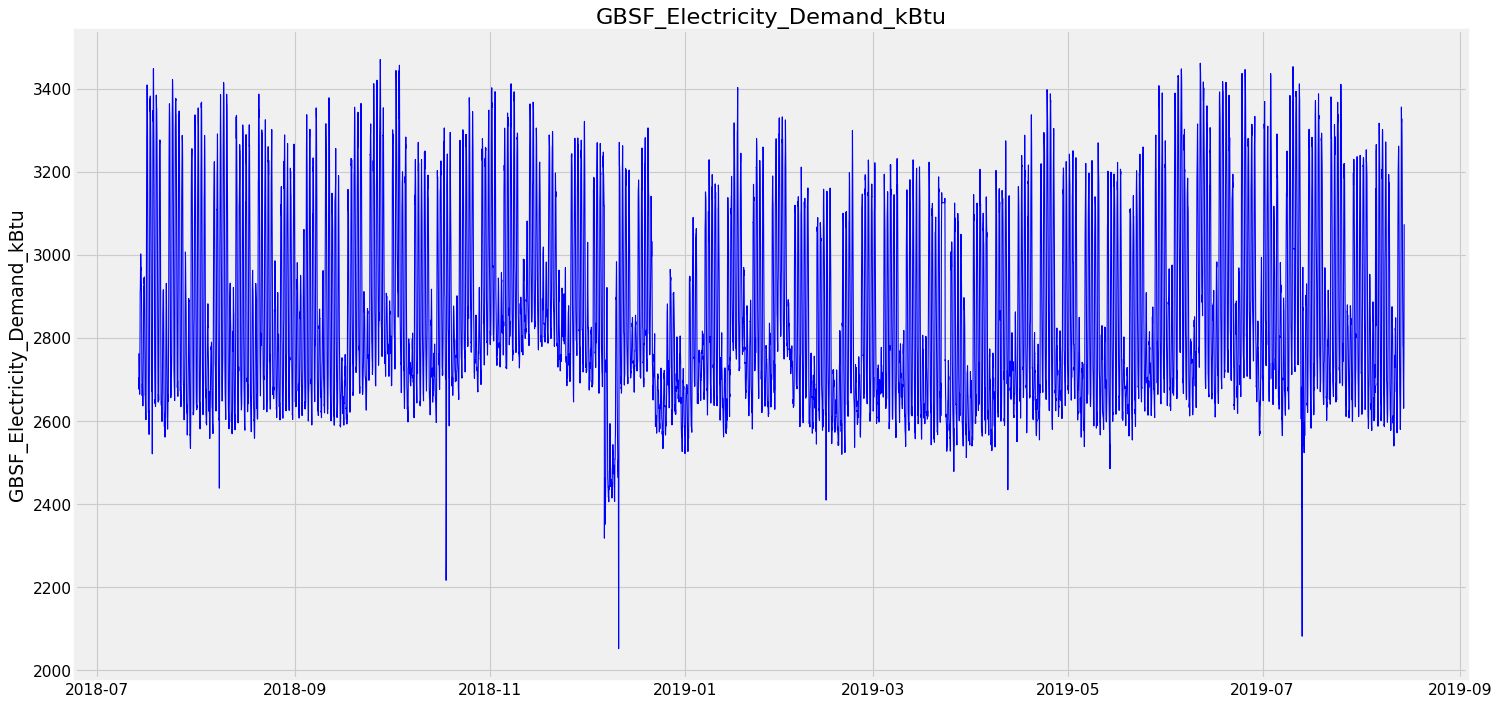

In [12]:
cleaned_df = drop_anomalies(a_df, kwargs)

In [13]:
cleaned_df

,Actual,Modeled,Anomalies,Result
Timestamp,,,,
2018-07-13 23:00:00,2762.912659,2697.104813,0,65.807845
2018-07-14 00:00:00,2712.991984,2659.955341,0,53.036644
2018-07-14 01:00:00,2676.531311,2668.352892,0,8.178419
2018-07-14 02:00:00,2696.758942,2650.147340,0,46.611601
2018-07-14 03:00:00,2704.625773,2650.008680,0,54.617094
2018-07-14 04:00:00,2698.198303,2650.644559,0,47.553745
2018-07-14 05:00:00,2677.467306,2640.760284,0,36.707021
2018-07-14 06:00:00,2664.565450,2641.362980,0,23.202470
2018-07-14 07:00:00,2708.064494,2666.625709,0,41.438785
